# Exploratory analysis of health data

My first approach. This notebook is intended to better understand the data from Brazilian Public Health Care System ([DATASUS](http://datasus.saude.gov.br/)). 

**================================================================================================**

## Initial setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sys
import importlib
import glob
import os

from dbfread import DBF

%matplotlib inline

In [2]:
# My repository.
repository = "/home/alex/Dropbox/repositories/doctoral_thesis/libraries/"

In [3]:
# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my libraries.
import utils.files as fi

## Hospitalization data set

In [4]:
# Where the data live.
directory = "/media/alex/ALEXDATA/data_sets/HEALTH/HOSPITALIZATION/"

# Directories for each state.
states_folders = sorted(glob.glob(directory + "/*/"))

# Labels for each state.
states_labels = sorted([state.name for state in os.scandir(directory)])

# Indexes for each state.
count = 1
print("State indexes:")
for index in range(len(states_labels)):
    if(count % 3) != 0:
        print(states_labels[index], ":", index, end="\t\t")
        count += 1
    else:
        print(states_labels[index], ":", index, end="\n")
        count += 1

State indexes:
AC : 0		AL : 1		AM : 2
AP : 3		BA : 4		CE : 5
DF : 6		ES : 7		GO : 8
MA : 9		MG : 10		MS : 11
MT : 12		PA : 13		PB : 14
PE : 15		PI : 16		PR : 17
RJ : 18		RN : 19		RO : 20
RR : 21		RS : 22		SC : 23
SE : 24		SP : 25		TO : 26


## Test for a given state

In [5]:
# Choose the state by index (as can be seen in the above list).
state_index = 12
state_label = states_labels[state_index]
state_folder = states_folders[state_index]

# Print choices.
print(state_label, ":", state_folder)

MT : /media/alex/ALEXDATA/data_sets/HEALTH/HOSPITALIZATION/MT/


In [6]:
# List with all dbf files.
files = fi.list_files(state_folder, "dbf")

# F strings only work on python <= 3.6 as far as I know.
print(f"Number of files: {len(files)}")

Number of files: 207


In [7]:
# Lets see the dimension sizes for each file, as well as the percentages of "J" cases (first
# log file).
log_file_name = "log_" + state_label + "1.txt"

# Open log file. Intended to not pollute this notebook.
with open(log_file_name, "w+") as f:

    print("*Folder:", state_folder, file=f)
    print("\nNUMBER\tSTATE\tFILE\tSHAPE\tJ-CASES", file=f)

    for file in files:
    
        # Read data and put them in a pandas data frame.
        DATA = pd.DataFrame(iter(DBF(state_folder + file)))
    
        if "DIAG_PRINC" in DATA.columns.values:
        
            # Search for "J" in "DIAG_PRINC" column.
            mask = ["J" in label for label in DATA.DIAG_PRINC]
    
            print(
                  files.index(file) + 1, state_label, file, DATA.shape, "%.3f %%" \
                  %(DATA.DIAG_PRINC[mask].size / DATA.DIAG_PRINC.size * 100), file=f
                 )        

## More details of a single file

In [8]:
# Select random file.
file = np.random.choice(files)
print(file)
DATA = pd.DataFrame(iter(DBF(state_folder + file)))

RDMT1504.dbf


In [9]:
DATA.head()

,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,DIAGSEC9,TPDISEC1,TPDISEC2,TPDISEC3,TPDISEC4,TPDISEC5,TPDISEC6,TPDISEC7,TPDISEC8,TPDISEC9
0,510000,2015,04,01,32944118000326,5115100545115,1,78593000,510895,19860723,...,,1,0,0,0,0,0,0,0,0
1,510000,2015,04,02,60922168001824,5115100451131,1,78200000,510250,19940609,...,,0,0,0,0,0,0,0,0,0
2,510000,2015,04,02,60922168001824,5115100451220,1,78270000,510775,19990329,...,,0,0,0,0,0,0,0,0,0
3,510000,2015,04,02,60922168001824,5115100451230,1,78200000,510250,19850916,...,,0,0,0,0,0,0,0,0,0
4,510000,2015,04,02,60922168001824,5115100451329,1,78200000,510250,19930516,...,,0,0,0,0,0,0,0,0,0


In [10]:
# All columns to the first log file.
with open(log_file_name, "a") as f:
    print("\n*Columns (" + str(DATA.columns.size) + ") of", file, ":\n", 
          file=f)
    
    count = 1
    for column in DATA.columns:
        if count % 5 != 0:
            print(column, end=", ", file=f)
            count += 1
        else:
            print(column, end=",\n", file=f)
            count += 1

## Applying filters

In [11]:
# My first approach.
# ANO_CMPT: Ano de competência.
# MES_CMPT: Mês de competência.
# MUNIC_RES: Código IBGE do município do paciente.
# SEXO: Sexo do paciente, onde 1=masculino e 3=feminino.
# VAL_TOT: Valor total.
# DT_INTER: Data da internação (AAAAMMDD).
# DT_SAIDA: Data de saída (AAAAMMDD).
# DIAG_PRINC: Código do diagnóstico principal.
# DIAG_SECUN: Código do diagnóstico secundário.
# MUNIC_MOV: Município do hospital.
# IDADE: Idade.
# DIAS_PERM: Dias de permanência.
# MORTE: Indica óbito (sim=1).
selected_columns = ["ANO_CMPT", "MES_CMPT", "SEXO", "VAL_TOT", "DT_INTER", 
                    "DT_SAIDA", "DIAG_PRINC", "DIAG_SECUN", "MUNIC_MOV", 
                    "MUNIC_RES" "IDADE", "DIAS_PERM", "MORTE"]

In [12]:
# Changing order of columns.
selected_columns = ["DT_INTER", "DT_SAIDA", "DIAS_PERM", "ANO_CMPT", "MES_CMPT", 
                    "IDADE", "SEXO", "DIAG_PRINC", "DIAG_SECUN", "MUNIC_MOV", 
                    "MUNIC_RES", "VAL_TOT", "MORTE"]

# Only the selected columns.
DATAs = DATA.loc[:, selected_columns]

# From string to pandas date time index.
DATAs.DT_INTER = pd.to_datetime(DATAs.DT_INTER)
DATAs.DT_SAIDA = pd.to_datetime(DATAs.DT_SAIDA)

# Internation data as index of the data frame.
DATAs.set_index("DT_INTER", inplace=True)
DATAs.sort_index(inplace=True)
DATAs.head()

,DT_SAIDA,DIAS_PERM,ANO_CMPT,MES_CMPT,IDADE,SEXO,DIAG_PRINC,DIAG_SECUN,MUNIC_MOV,MUNIC_RES,VAL_TOT,MORTE
DT_INTER,,,,,,,,,,,,
2014-10-01,2015-01-31,31,2015,04,31,1,F200,0000,510340,510340,1540.74,0
2014-10-01,2015-01-31,31,2015,04,44,3,F200,0000,510340,510340,1540.74,0
2014-10-01,2015-01-31,31,2015,04,66,1,F200,0000,510340,510340,1540.74,0
2014-10-01,2015-01-31,31,2015,04,62,1,F200,0000,510340,510340,1540.74,0
2014-10-01,2015-01-31,31,2015,04,95,1,F29,0000,510340,510340,1540.74,0


### Consistency of dates

In [13]:
# Consistency of days in hospital.
mask1 = (DATAs.DT_SAIDA - DATAs.index) == pd.to_timedelta(DATAs.DIAS_PERM, unit="D")
print("Conflict percentage: %.2f %%" %(100 - np.sum(mask1) / DATAs.shape[0] * 100))
DATAs = DATAs[mask1]

Conflict percentage: 0.78 %


### Selecting respiratory diseases

In [14]:
mask2 = ["J" in disease for disease in DATAs.DIAG_PRINC.values]
DATAs = DATAs[mask2]

# Add a column for counting the internations per day.
DATAs["COUNT"] = 1

# Count of daily respiratory deseases
COUNT = DATAs.groupby(DATAs.index.date).count()["COUNT"]

### Time series for this file

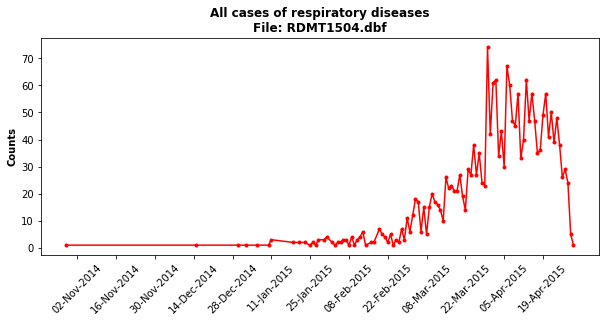

In [15]:
# Figure.
plt.figure(figsize=(10, 4))
plt.plot(COUNT.index, COUNT.values, ".-r")
plt.ylabel("Counts", fontweight="bold")
plt.title("All cases of respiratory diseases\nFile: " + file, fontweight="bold")

# Adjustments.
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%Y"))
plt.xticks(pd.date_range(pd.to_datetime(COUNT.index[0]), pd.to_datetime(COUNT.index[-1]), 
                         freq="2W"))
plt.xticks(rotation=45);

## Put all data together

In [16]:
# My package.
import datasus.tools as sus

In [17]:
# Incorpore the onging changes.
importlib.reload(sus);

In [18]:
# Read all data. All diseases for all locations in selected state. See the corresponding log 
# file.
log_file_name = "log_" + state_label + "2.txt"
DATA = sus.data_frame(directory + state_label + "/", verbose=True, log_file=log_file_name)

100% (207 of 207) |######################| Elapsed Time: 0:15:25 Time:  0:15:25


In [19]:
# Final size.
DATA.shape

(3250292, 12)

In [20]:
# Selecting only respiratory diseases.
DATAs = sus.data_frame_selection(DATA, disease_codes=["J"])

In [21]:
DATAs.shape

(512154, 12)

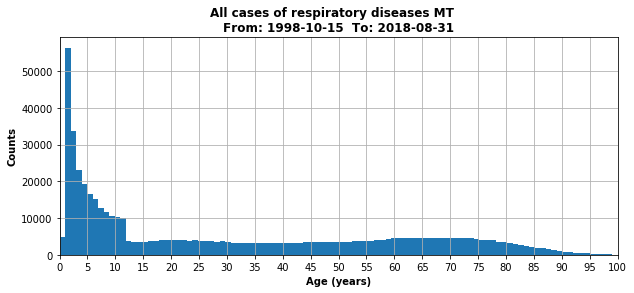

In [22]:
# Distribution of ages.
plt.figure(figsize=(10, 4))
DATAs.IDADE.hist(bins=100)
plt.xticks(range(0, 105, 5))
plt.xlim((0, 100))
plt.xlabel("Age (years)", fontweight="bold")
plt.ylabel("Counts", fontweight="bold")
plt.title("All cases of respiratory diseases " + state_label + "   " + 
          "\nFrom: " + str(DATAs.index[0])[0:10] +  
          "  To: " + str(DATAs.index[-1])[0:10], 
          fontweight="bold")
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "1.jpg", 
            dpi=400, bbox_inches="tight")

In [23]:
# Years of internation.
np.unique(DATAs.index.year)

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [24]:
# Counting occurences.
DATAs = DATAs.assign(COUNT=1)
COUNTf = DATAs.groupby(DATAs.index.date).count().COUNT

# Two more columns for the month.
COUNTf = pd.DataFrame(COUNTf)
COUNTf.index = pd.to_datetime(COUNTf.index)
COUNTf["MONTH"] = COUNTf.index.month
COUNTf["MONTH_LABEL"] = COUNTf.index.month_name()
COUNTf.head()

,COUNT,MONTH,MONTH_LABEL
1998-10-15,1,10,October
1998-11-05,1,11,November
1998-11-06,1,11,November
1998-11-18,1,11,November
1998-11-24,1,11,November


In [25]:
DATAs = DATAs.assign(COUNT=1)

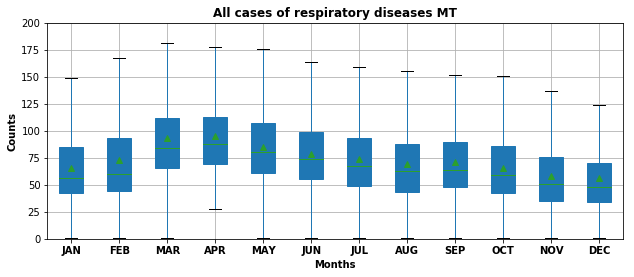

In [26]:
# Box plot for each month.
COUNTf.boxplot(column=["COUNT"], by="MONTH", notch=False, patch_artist=True, showmeans=True, 
               showfliers=False, figsize=(10, 4))
plt.ylim((0, 200))
ax = plt.gca()
fig = plt.gcf()
ax.set_xlabel("Months", fontweight="bold")
ax.set_ylabel("Counts", fontweight="bold")
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", 
                    "MAY", "JUN", "JUL", "AUG", 
                    "SEP", "OCT", "NOV", "DEC"], fontweight="bold")
ax.set_title("All cases of respiratory diseases " + state_label, fontweight="bold")
fig.suptitle("")
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "2.jpg", 
            dpi=400, bbox_inches="tight")

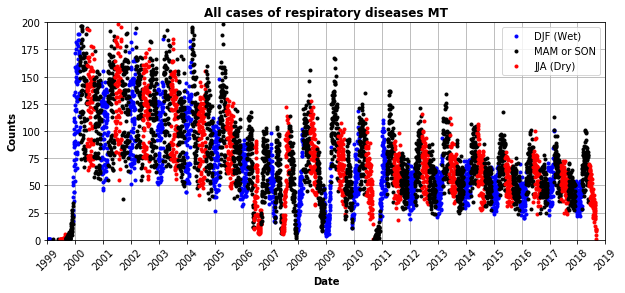

In [27]:
# Figure settings.
plt.figure(figsize=(10, 4))

# Seasons. Maybe it is not the better way to do it.
# Wet season.
DEC = pd.to_datetime(COUNTf.index).month_name() == "December" 
JAN = pd.to_datetime(COUNTf.index).month_name() == "January" 
FEB = pd.to_datetime(COUNTf.index).month_name() == "February" 
WET = DEC | JAN | FEB

# Transition.
MAR = pd.to_datetime(COUNTf.index).month_name() == "March" 
APR = pd.to_datetime(COUNTf.index).month_name() == "April" 
MAY = pd.to_datetime(COUNTf.index).month_name() == "May" 
T1 = MAR | APR | MAY

# Dry season.
JUN = pd.to_datetime(COUNTf.index).month_name() == "June" 
JUL = pd.to_datetime(COUNTf.index).month_name() == "July" 
AUG = pd.to_datetime(COUNTf.index).month_name() == "August" 
DRY = JUN | JUL | AUG

# Transition.
SEP = pd.to_datetime(COUNTf.index).month_name() == "September" 
OUT = pd.to_datetime(COUNTf.index).month_name() == "October" 
NOV = pd.to_datetime(COUNTf.index).month_name() == "November" 
T2 = SEP | OUT | NOV

# Plot.
plt.plot(COUNTf.index[WET], COUNTf.COUNT[WET], ".b", label="DJF (Wet)")
plt.plot(COUNTf.index[T1], COUNTf.COUNT[T1], ".k", label="MAM or SON")
plt.plot(COUNTf.index[DRY], COUNTf.COUNT[DRY], ".r", label="JJA (Dry)")
plt.plot(COUNTf.index[T2], COUNTf.COUNT[T2], ".k", label="")

# Labels.
plt.title("All cases of respiratory diseases " + state_label, fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Counts", fontweight="bold")

# Adjustments.
plt.ylim((0, 200))
plt.xlim((pd.Timestamp("1999"),pd.Timestamp("2019")))
plt.xticks(pd.date_range("1999", "2019", freq="YS"), rotation=45)
plt.grid()
plt.legend()
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "3.jpg", 
            dpi=400, bbox_inches="tight")

## Geolocalization data of Brazilian municipalities

In [28]:
# Data from Brazilian Institute of Geography and Statistics (IBGE).
ibge_file = "/media/alex/ALEXDATA/data_sets/IBGE/BR_Localidades_2010_v1.dbf"

# Put data in a pandas dataframe.
IBGE = pd.DataFrame(iter(DBF(ibge_file, encoding="iso-8859-1")))
IBGE.set_index("ID", inplace=True)

In [29]:
# All columns of the dataframe
IBGE.columns

Index(['CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'NM_UF', 'CD_NIVEL', 'CD_CATEGOR', 'NM_CATEGOR',
       'NM_LOCALID', 'LONG', 'LAT', 'ALT', 'GMRotation'],
      dtype='object')

In [30]:
# CAtegories of locations.
IBGE.NM_CATEGOR.unique()

array(['CIDADE', 'VILA', 'POVOADO', 'ALDEIA INDÍGENA', 'NÚCLEO',
       'PROJETO DE ASSENTAMENTO', 'LUGAREJO', 'AUI'], dtype=object)

In [31]:
# Only data for municipalities (CIDADE).
IBGE = IBGE.loc[IBGE.NM_CATEGOR == "CIDADE", :]

print("Number of municipalities:", IBGE.shape[0])

Number of municipalities: 5565


In [32]:
# Dictionary for states labels. This dictionary is intended to merging the two 
# dataframes (data from SUS and IBGE).
states_dic = dict(zip(states_labels, 
                      ['ACRE', 'ALAGOAS', 'AMAZONAS', 
                       'AMAPÁ', 'BAHIA', 'CEARÁ',
                       'DISTRITO FEDERAL', 'ESPÍRITO SANTO','GOIÁS',
                       'MARANHÃO', 'MINAS GERAIS', 'MATO GROSSO DO SUL',
                       'MATO GROSSO', 'PARÁ', 'PARAÍBA',
                       'PERNAMBUCO', 'PIAUÍ', 'PARANÁ',
                       'RIO DE JANEIRO','RIO GRANDE DO NORTE', 'RONDÔNIA',
                       'RORAIMA','RIO GRANDE DO SUL', 'SANTA CATARINA',
                       'SERGIPE', 'SÃO PAULO','TOCANTINS']))
states_dic

{'AC': 'ACRE',
 'AL': 'ALAGOAS',
 'AM': 'AMAZONAS',
 'AP': 'AMAPÁ',
 'BA': 'BAHIA',
 'CE': 'CEARÁ',
 'DF': 'DISTRITO FEDERAL',
 'ES': 'ESPÍRITO SANTO',
 'GO': 'GOIÁS',
 'MA': 'MARANHÃO',
 'MG': 'MINAS GERAIS',
 'MS': 'MATO GROSSO DO SUL',
 'MT': 'MATO GROSSO',
 'PA': 'PARÁ',
 'PB': 'PARAÍBA',
 'PE': 'PERNAMBUCO',
 'PI': 'PIAUÍ',
 'PR': 'PARANÁ',
 'RJ': 'RIO DE JANEIRO',
 'RN': 'RIO GRANDE DO NORTE',
 'RO': 'RONDÔNIA',
 'RR': 'RORAIMA',
 'RS': 'RIO GRANDE DO SUL',
 'SC': 'SANTA CATARINA',
 'SE': 'SERGIPE',
 'SP': 'SÃO PAULO',
 'TO': 'TOCANTINS'}

In [33]:
# Only municipalities for the desired state.
IBGE = IBGE.loc[IBGE.NM_UF == states_dic[states_labels[state_index]], :]

print("Number of municipalities in %s: " %states_dic[states_labels[state_index]] + 
      str(IBGE.shape[0]))

Number of municipalities in MATO GROSSO: 141


## Selecting some municipalities

In [34]:
# Municipalities close to Alta Floresta. 
municipalities_af = dict(zip(["APIACÁS", "PARANAÍTA", "NOVA BANDEIRANTES", 
                              "NOVA MONTE VERDE", "ALTA FLORESTA", "CARLINDA", 
                              "NOVA CANAÃ DO NORTE"], 
                             ["510080", "510629", "510615", 
                              "510895", "510025", "510279",
                              "510621"]))

In [35]:
# Grouping municipalities.
DFs = []
for place in municipalities_af.values():
    mask = DATAs.MUNIC_RES == place
    DFs.append(DATAs[mask])
        
DATAs_af = pd.concat(DFs)

# Data frame for municipalities close to Alta floresta.
DATAs_af.shape

(26956, 13)

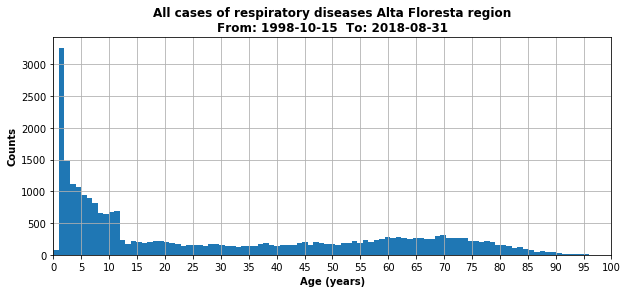

In [36]:
# Distribution of ages.
plt.figure(figsize=(10, 4))
DATAs_af.IDADE.hist(bins=100)
plt.xticks(range(0, 105, 5))
plt.xlim((0, 100))
plt.xlabel("Age (years)", fontweight="bold")
plt.ylabel("Counts", fontweight="bold")
plt.title("All cases of respiratory diseases Alta Floresta region" + 
          "\nFrom: " + str(DATAs.index[0])[0:10] +  
          "  To: " + str(DATAs.index[-1])[0:10], 
          fontweight="bold")
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "4.jpg", 
            dpi=400, bbox_inches="tight")

In [37]:
# Counting occurences in these municipalities.
COUNTf_af = DATAs_af.groupby(DATAs_af.index.date).count().iloc[:, 1]

# Two more columns for the month.
COUNTf_af = pd.DataFrame(COUNTf_af)
COUNTf_af.rename(columns={"DIAS_PERM": "COUNT"}, inplace=True)
COUNTf_af["MONTH"] = pd.to_datetime(COUNTf_af.index).month
COUNTf_af["MONTH_LABEL"] = pd.to_datetime(COUNTf_af.index).month_name()
COUNTf_af.head()

,COUNT,MONTH,MONTH_LABEL
1999-07-27,1,7,July
1999-10-01,1,10,October
1999-10-13,1,10,October
1999-11-02,1,11,November
1999-11-05,2,11,November


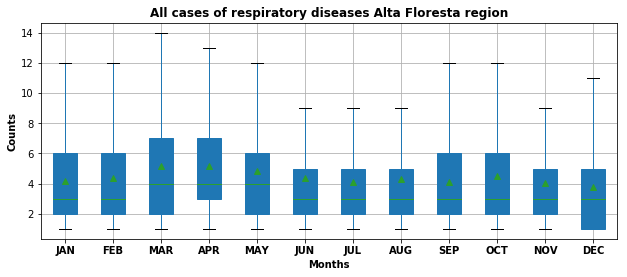

In [38]:
# Box plot for each month.
COUNTf_af.boxplot(column=["COUNT"], by="MONTH", notch=False, patch_artist=True, showmeans=True, 
                  showfliers=False, figsize=(10, 4))
ax = plt.gca()
fig = plt.gcf()
ax.set_xlabel("Months", fontweight="bold")
ax.set_ylabel("Counts", fontweight="bold")
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", 
                    "MAY", "JUN", "JUL", "AUG", 
                    "SEP", "OCT", "NOV", "DEC"], fontweight="bold")
ax.set_title("All cases of respiratory diseases Alta Floresta region", fontweight="bold")
fig.suptitle("")
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "5.jpg", 
            dpi=400, bbox_inches="tight")

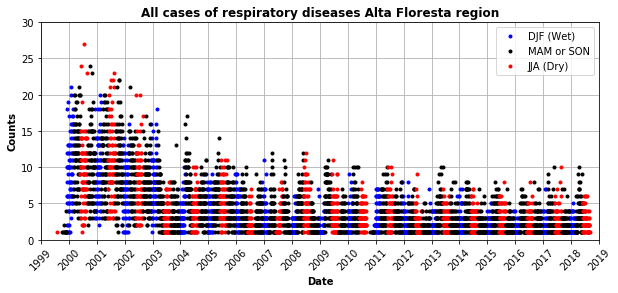

In [39]:
# Figure settings.
plt.figure(figsize=(10, 4))

# Seasons. Maybe it is not the better way to do it.
# Wet season.
DEC = pd.to_datetime(COUNTf_af.index).month_name() == "December" 
JAN = pd.to_datetime(COUNTf_af.index).month_name() == "January" 
FEB = pd.to_datetime(COUNTf_af.index).month_name() == "February" 
WET = DEC | JAN | FEB

# Transition.
MAR = pd.to_datetime(COUNTf_af.index).month_name() == "March" 
APR = pd.to_datetime(COUNTf_af.index).month_name() == "April" 
MAY = pd.to_datetime(COUNTf_af.index).month_name() == "May" 
T1 = MAR | APR | MAY

# Dry season.
JUN = pd.to_datetime(COUNTf_af.index).month_name() == "June" 
JUL = pd.to_datetime(COUNTf_af.index).month_name() == "July" 
AUG = pd.to_datetime(COUNTf_af.index).month_name() == "August" 
DRY = JUN | JUL | AUG

# Transition.
SEP = pd.to_datetime(COUNTf_af.index).month_name() == "September" 
OUT = pd.to_datetime(COUNTf_af.index).month_name() == "October" 
NOV = pd.to_datetime(COUNTf_af.index).month_name() == "November" 
T2 = SEP | OUT | NOV

# Plot.
plt.plot(COUNTf_af.index[WET], COUNTf_af.COUNT[WET], ".b", label="DJF (Wet)")
plt.plot(COUNTf_af.index[T1], COUNTf_af.COUNT[T1], ".k", label="MAM or SON")
plt.plot(COUNTf_af.index[DRY], COUNTf_af.COUNT[DRY], ".r", label="JJA (Dry)")
plt.plot(COUNTf_af.index[T2], COUNTf_af.COUNT[T2], ".k", label="")

# Labels.
plt.title("All cases of respiratory diseases Alta Floresta region", fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Counts", fontweight="bold")

# Adjustments.
plt.ylim((0, 30))
plt.xlim((pd.Timestamp("1999"),pd.Timestamp("2019")))
plt.xticks(pd.date_range("1999", "2019", freq="YS"), rotation=45)
plt.grid()
plt.legend()
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "6.jpg", 
            dpi=400, bbox_inches="tight")

In [40]:
# Children and elderly.
mask3 = (DATAs_af.IDADE <= 15).values | (DATAs_af.IDADE >= 60).values
DATAs_af_i = DATAs_af[mask3]
DATAs_af_i.shape

(19319, 13)

In [41]:
# Counting occurences in these municipalities.
COUNTf_af_i = DATAs_af_i.groupby(DATAs_af_i.index.date).count().iloc[:, 1]

# Two more columns for the month.
COUNTf_af_i = pd.DataFrame(COUNTf_af_i)
COUNTf_af_i.rename(columns={"DIAS_PERM": "COUNT"}, inplace=True)
COUNTf_af_i["MONTH"] = pd.to_datetime(COUNTf_af_i.index).month
COUNTf_af_i["MONTH_LABEL"] = pd.to_datetime(COUNTf_af_i.index).month_name()
COUNTf_af_i.head()

,COUNT,MONTH,MONTH_LABEL
1999-10-13,1,10,October
1999-11-05,1,11,November
1999-11-16,1,11,November
1999-11-28,1,11,November
1999-11-29,1,11,November


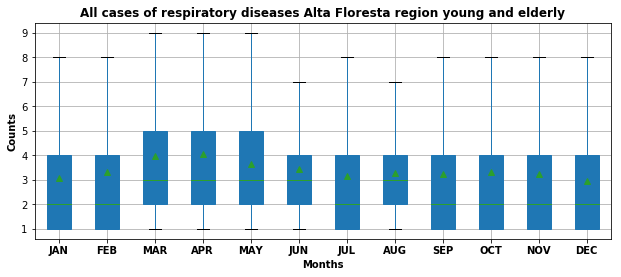

In [42]:
# Box plot for each month.
COUNTf_af_i.boxplot(column=["COUNT"], by="MONTH", notch=False, patch_artist=True, 
                    showmeans=True, showfliers=False, figsize=(10, 4))
ax = plt.gca()
fig = plt.gcf()
ax.set_xlabel("Months", fontweight="bold")
ax.set_ylabel("Counts", fontweight="bold")
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", 
                    "MAY", "JUN", "JUL", "AUG", 
                    "SEP", "OCT", "NOV", "DEC"], fontweight="bold")
ax.set_title("All cases of respiratory diseases Alta Floresta region young and elderly", 
             fontweight="bold")
fig.suptitle("")
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "7.jpg", 
            dpi=400, bbox_inches="tight")

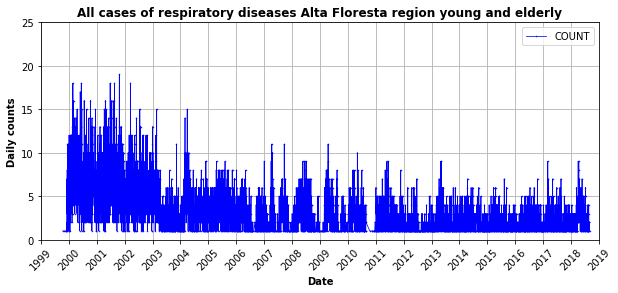

In [43]:
# Time series.
plt.figure(figsize=(10, 4))
plt.plot(COUNTf_af_i.index, COUNTf_af_i.COUNT, ".-b", linewidth=0.75, markersize=1)
plt.title("All cases of respiratory diseases Alta Floresta region young and elderly", 
          fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Daily counts", fontweight="bold")

# Adjustments.
plt.ylim((0, 25))
plt.xlim((pd.Timestamp("1999"),pd.Timestamp("2019")))
plt.xticks(pd.date_range("1999", "2019", freq="YS"), rotation=45)
plt.grid()
plt.legend()
plt.savefig("/home/alex/Dropbox/repositories/doctoral_thesis/" + \
            "figures/health_data_counts_" + state_label + "8.jpg", 
            dpi=400, bbox_inches="tight")